In [2]:
# Importacion de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy import stats

# Configuracion fija para graficos
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# Random_state para kmeans
RANDOM_STATE = 42


In [3]:
# Ruta del archivo 
ruta = "datos.csv"

# Lectura de archivos, primero como csv y en caso de no ser compatible se continua con excel.
try:
    df = pd.read_csv(ruta)
except Exception as e:
    try:
        df = pd.read_excel(ruta)
    except Exception as e2:
        raise RuntimeError(f"no pude leer el archivo. reviso la ruta y extension. error: {e} | {e2}")

# Revision de las primeras filas del archivo
print("shape del df:", df.shape)
df.head()


shape del df: (15079, 5)


,Customer ID,Age,Gender,Annual Income,Spending Score
0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,30,Male,151479,89
1,1770b26f-493f-46b6-837f-4237fb5a314e,58,Female,185088,95
2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,62,Female,70912,76
3,9795712a-ad19-47bf-8886-4f997d6046e3,23,Male,55460,57
4,64139426-2226-4cd6-bf09-91bce4b4db5e,24,Male,153752,76


In [4]:
# Revision nombres de columnas tal como vienen
print("columnas:", df.columns.tolist())

# Revision  tipos de datos y nulos
print("\ninfo del df:")
df.info()

print("\nconteo de nulos por columna:")
print(df.isnull().sum())

# Verificacion de filas duplicadas
print("\nfilas duplicadas:", df.duplicated().sum())

# Revision de estadisticas basicas de columnas numericas
print("\nstats numericas:")
df.describe().T


columnas: ['Customer ID', 'Age', 'Gender', 'Annual Income', 'Spending Score']

info del df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15079 entries, 0 to 15078
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer ID     15079 non-null  object
 1   Age             15079 non-null  int64 
 2   Gender          15079 non-null  object
 3   Annual Income   15079 non-null  int64 
 4   Spending Score  15079 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 589.2+ KB

conteo de nulos por columna:
Customer ID       0
Age               0
Gender            0
Annual Income     0
Spending Score    0
dtype: int64

filas duplicadas: 0

stats numericas:


,count,mean,std,min,25%,50%,75%,max
Age,15079.0,54.191591,21.119207,18.0,36.0,54.0,72.0,90.0
Annual Income,15079.0,109742.880562,52249.425866,20022.0,64141.0,109190.0,155008.0,199974.0
Spending Score,15079.0,50.591617,28.726977,1.0,26.0,51.0,75.0,100.0


In [ ]:
# Limpieza de Datos

# Busqueda de  columna por palabras clave
def encontrar_col(df, keys):
    # normaliza: minuscula y sin espacios
    norm = lambda s: s.lower().replace(" ", "").replace("_","").replace("-","")
    for c in df.columns:
        nc = norm(c)
        if all(k in nc for k in keys):
            return c
    return None

col_age    = encontrar_col(df, ["age"])                       
col_income = encontrar_col(df, ["annual","income"]) or encontrar_col(df, ["income"])   
col_score  = encontrar_col(df, ["spending","score"]) or encontrar_col(df, ["score"])   

print("columnas detectadas:", col_age, "|", col_income, "|", col_score)

# validacion que existan
if any(x is None for x in [col_age, col_income, col_score]):
    raise ValueError("no se detectaron correctamente las columnas de age/income/score. revisar df.columns")

# 1) quitar duplicados
filas_antes = df.shape[0]
df = df.drop_duplicates().copy()
filas_despues = df.shape[0]
print(f"duplicados eliminados: {filas_antes - filas_despues}")

# 2) asegurar tipo numerico en las 3 columnas que se usaran
for c in [col_age, col_income, col_score]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 3) revisar nulos antes de filtrar
print("\nnulos antes de filtrar:")
print(df[[col_age, col_income, col_score]].isnull().sum())

# 4) eliminar filas con nulos solo en las columnas que se usaran
df = df.dropna(subset=[col_age, col_income, col_score]).copy()
print("\nshape despues de limpiar nulos en las variables clave:", df.shape)



columnas detectadas: Age | Annual Income | Spending Score
duplicados eliminados: 0

nulos antes de filtrar:
Age               0
Annual Income     0
Spending Score    0
dtype: int64

shape despues de limpiar nulos en las variables clave: (15079, 5)


In [ ]:
# Chequeo de outliers usando z-score

from scipy import stats
vals = df[[col_age, col_income, col_score]].to_numpy()
z = np.abs(stats.zscore(vals, nan_policy="omit"))
filas_con_outlier = (z > 3).any(axis=1)  # umbral clasico 3 desv
print(f"posibles outliers (conteo de filas): {filas_con_outlier.sum()} de {len(df)}")

# Se arma la matriz X con las 3 variables seleccionadas


cols_modelo = [col_age, col_income, col_score]
X = df[cols_modelo].to_numpy()

print("variables seleccionadas:", cols_modelo)
print("shape de X:", X.shape)


posibles outliers (conteo de filas): 0 de 15079
variables seleccionadas: ['Age', 'Annual Income', 'Spending Score']
shape de X: (15079, 3)


In [7]:
# estandariza variables numericas con media 0 y desviacion 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# valida dimensiones para seguir
print("shape X_scaled:", X_scaled.shape)


shape X_scaled: (15079, 3)


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wina

,k,inercia,silhouette
0,2,33876.066413,0.244291
1,3,26986.804223,0.240049
2,4,21463.203946,0.264149
3,5,18010.372652,0.266842
4,6,14885.534788,0.289854
5,7,13034.533098,0.282047
6,8,11315.075024,0.279877
7,9,10610.282825,0.288545
8,10,10048.231508,0.276424


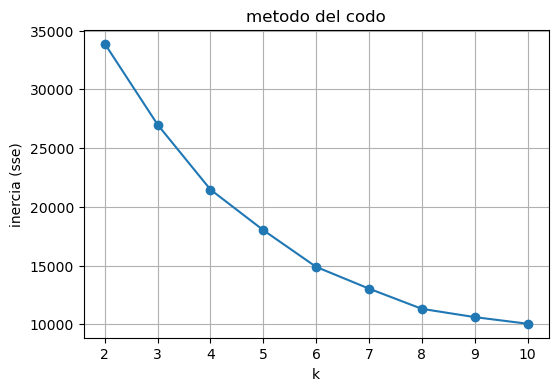

k_final sugerido por silhouette: 6


In [ ]:
# calcula inercia (sse) y silhouette para un rango simple de k
k_vals = range(2, 11)
inertias, sils = [], []

for k in k_vals:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

# muestra tabla corta con resultados
resultados = pd.DataFrame({"k": list(k_vals), "inercia": inertias, "silhouette": sils})
display(resultados)

# grafica el codo (usa sse/inercia)
plt.plot(resultados["k"], resultados["inercia"], marker="o")
plt.xlabel("k")
plt.ylabel("inercia (sse)")
plt.title("metodo del codo")
plt.grid(True)
plt.show()

# k elegido por mayor silhouette
k_final = int(resultados.loc[resultados["silhouette"].idxmax(), "k"])
print("k_final sugerido por silhouette:", k_final)


In [ ]:
# entrena kmeans con k_final 
kmeans = KMeans(n_clusters=k_final, init="k-means++", n_init=10, random_state=RANDOM_STATE)
df["cluster"] = kmeans.fit_predict(X_scaled)

# guarda metricas clave para el informe
inercia_final = kmeans.inertia_
sil_final = silhouette_score(X_scaled, df["cluster"])

print("inercia final:", round(inercia_final, 2))
print("silhouette final:", round(sil_final, 4))

# muestra tamanos por cluster
print("tamanos por cluster:\n", df["cluster"].value_counts().sort_index().to_string())


inercia final: 14885.53
silhouette final: 0.2899
tamanos por cluster:
 cluster
0    2505
1    2427
2    2412
3    2606
4    2574
5    2555


In [10]:
# convierte los centroides a la escala original de las variables
centroides_orig = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cols_modelo
).round(1)
centroides_orig.index.name = "cluster"
print("centroides (escala original):")
print(centroides_orig.to_string())


centroides (escala original):
          Age  Annual Income  Spending Score
cluster                                     
0        74.5        80636.0            25.1
1        45.9       160950.7            22.4
2        34.1       142729.4            76.3
3        60.2        59841.7            78.6
4        74.4       155171.1            66.0
5        34.6        63645.4            34.0


In [11]:
# calcula medias por cluster para las variables seleccionadas
perf_mean = (
    df.groupby("cluster")[cols_modelo]
      .mean(numeric_only=True)
      .round(1)
)

# calcula medianas por cluster (para comparar contra medias)
perf_median = (
    df.groupby("cluster")[cols_modelo]
      .median(numeric_only=True)
      .round(1)
)

# calcula cantidad de registros por cluster
tam = df["cluster"].value_counts().sort_index()
perf = perf_mean.copy()
perf["n_clientes"] = tam

print("perfil con medias y tamanos por cluster:")
display(perf)

print("medianas por cluster (referencia):")
display(perf_median)


perfil con medias y tamanos por cluster:


,Age,Annual Income,Spending Score,n_clientes
cluster,,,,
0,74.5,80705.3,25.1,2505
1,45.9,160990.6,22.4,2427
2,34.1,142626.3,76.3,2412
3,60.3,59829.6,78.6,2606
4,74.4,155183.7,66.0,2574
5,34.6,63619.8,34.0,2555


medianas por cluster (referencia):


,Age,Annual Income,Spending Score
cluster,,,
0,76.0,79969.0,24.0
1,46.0,163735.0,21.0
2,33.0,144279.0,77.0
3,60.0,57925.0,79.0
4,75.0,156689.5,66.0
5,34.0,60435.0,34.0


In [ ]:
# genera etiquetas legibles segun el nombre original de cada variable
def etiqueta_simple(col):
    col_l = col.lower()
    if "age" in col_l:
        return "edad_prom"
    if "income" in col_l:
        return "ingreso_prom"
    if "spending" in col_l and "score" in col_l:
        return "score_prom"
    # por defecto usa el nombre base con sufijo _prom
    return f"{col}_prom"

ren_map = {c: etiqueta_simple(c) for c in cols_modelo}

perf_legible = perf.rename(columns=ren_map)
print("tabla de perfiles de clientes agrupados")
display(perf_legible)


tabla de perfiles de clientes agrupados


,edad_prom,ingreso_prom,score_prom,n_clientes
cluster,,,,
0,74.5,80705.3,25.1,2505
1,45.9,160990.6,22.4,2427
2,34.1,142626.3,76.3,2412
3,60.3,59829.6,78.6,2606
4,74.4,155183.7,66.0,2574
5,34.6,63619.8,34.0,2555


In [19]:
# identifica el cluster con mayor ingreso promedio
col_ingreso = next((c for c in perf_legible.columns if "ingreso_prom" in c), None)
col_score   = next((c for c in perf_legible.columns if "score_prom" in c), None)
col_edad    = next((c for c in perf_legible.columns if "edad_prom" in c), None)

if col_ingreso:
    cl_mayor_ingreso = int(perf_legible[col_ingreso].idxmax())
    print(f"cluster con mayor ingreso promedio: {cl_mayor_ingreso} ({perf_legible.loc[cl_mayor_ingreso, col_ingreso]})")

if col_score:
    cl_mayor_score = int(perf_legible[col_score].idxmax())
    print(f"cluster con mayor score promedio: {cl_mayor_score} ({perf_legible.loc[cl_mayor_score, col_score]})")

if col_edad:
    cl_mayor_edad = int(perf_legible[col_edad].idxmax())
    print(f"cluster con mayor edad promedio: {cl_mayor_edad} ({perf_legible.loc[cl_mayor_edad, col_edad]})")

# muestra tamanos por cluster en texto simple
print("\ntamanos por cluster:")
print(df["cluster"].value_counts().sort_index().to_string())


cluster con mayor ingreso promedio: 1 (160990.6)
cluster con mayor score promedio: 3 (78.6)
cluster con mayor edad promedio: 0 (74.5)

tamanos por cluster:
cluster
0    2505
1    2427
2    2412
3    2606
4    2574
5    2555
